# Задание 6: Рекуррентные нейронные сети (RNNs)

Это задание адаптиповано из Deep NLP Course at ABBYY (https://github.com/DanAnastasyev/DeepNLP-Course) с разрешения автора - Даниила Анастасьева. Спасибо ему огромное!

In [1]:
# !pip3 -qq install torch==0.4.1
# !pip3 -qq install bokeh==0.13.0
# !pip3 -qq install gensim==3.6.0
# !pip3 -qq install nltk
# !pip3 -qq install scikit-learn==0.20.2

In [1]:
!pip3 -qq install torch bokeh gensim nltk scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 15.3 MB/s eta 0:00:00


In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor

np.random.seed(42)

# Рекуррентные нейронные сети (RNNs)

## POS Tagging

Мы рассмотрим применение рекуррентных сетей к задаче sequence labeling (последняя картинка).

![RNN types](http://karpathy.github.io/assets/rnn/diags.jpeg)

*From [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*

Самые популярные примеры для такой постановки задачи - Part-of-Speech Tagging и Named Entity Recognition.

Мы порешаем сейчас POS Tagging для английского.

Будем работать с таким набором тегов:
- ADJ - adjective (new, good, high, ...)
- ADP - adposition (on, of, at, ...)
- ADV - adverb (really, already, still, ...)
- CONJ - conjunction (and, or, but, ...)
- DET - determiner, article (the, a, some, ...)
- NOUN - noun (year, home, costs, ...)
- NUM - numeral (twenty-four, fourth, 1991, ...)
- PRT - particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- . - punctuation marks (. , ;)
- X - other (ersatz, esprit, dunno, ...)

Скачаем данные:

In [3]:
import nltk
from sklearn.model_selection import train_test_split

nltk.download('brown')
nltk.download('universal_tagset')

data = nltk.corpus.brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


Пример размеченного предложения:

In [4]:
for word, tag in data[0]:
    print('{:15}\t{}'.format(word, tag))

The            	DET
Fulton         	NOUN
County         	NOUN
Grand          	ADJ
Jury           	NOUN
said           	VERB
Friday         	NOUN
an             	DET
investigation  	NOUN
of             	ADP
Atlanta's      	NOUN
recent         	ADJ
primary        	NOUN
election       	NOUN
produced       	VERB
``             	.
no             	DET
evidence       	NOUN
''             	.
that           	ADP
any            	DET
irregularities 	NOUN
took           	VERB
place          	NOUN
.              	.


In [5]:
print(data[0])

[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')]


Построим разбиение на train/val/test - наконец-то, всё как у нормальных людей.

На train будем учиться, по val - подбирать параметры и делать всякие early stopping, а на test - принимать модель по ее финальному качеству.

In [6]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

print('Words count in train set:', sum(len(sent) for sent in train_data))
print('Words count in val set:', sum(len(sent) for sent in val_data))
print('Words count in test set:', sum(len(sent) for sent in test_data))

Words count in train set: 739769
Words count in val set: 130954
Words count in test set: 290469


Построим маппинги из слов в индекс и из тега в индекс:


In [7]:
words = {word for sample in train_data for word, tag in sample}
word2ind = {word: ind + 1 for ind, word in enumerate(words)}
word2ind['<pad>'] = 0

tags = {tag for sample in train_data for word, tag in sample}
tag2ind = {tag: ind + 1 for ind, tag in enumerate(tags)}
tag2ind['<pad>'] = 0

print(f'Unique words in train = {len(word2ind)}. Tags = {tags}')

Unique words in train = 45441. Tags = {'.', 'PRT', 'VERB', 'ADV', 'NUM', 'NOUN', 'CONJ', 'X', 'ADP', 'PRON', 'DET', 'ADJ'}


In [8]:
word2ind['a'], tag2ind['ADV']

(18713, 4)

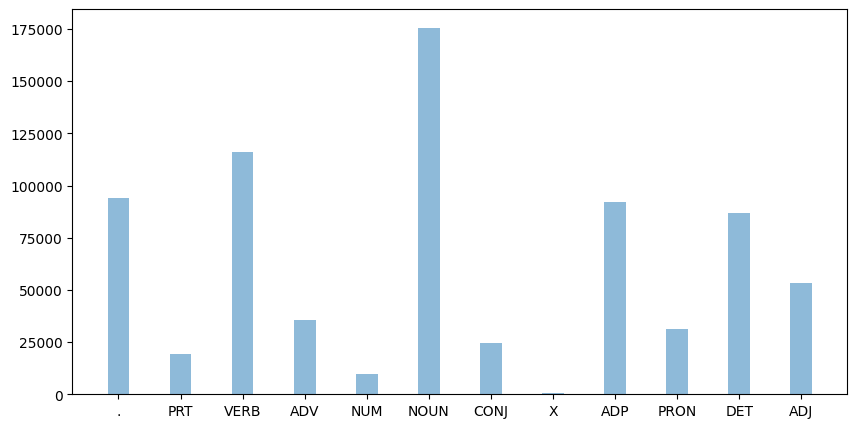

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

tag_distribution = Counter(tag for sample in train_data for _, tag in sample)
tag_distribution = [tag_distribution[tag] for tag in tags]

plt.figure(figsize=(10, 5))

bar_width = 0.35
plt.bar(np.arange(len(tags)), tag_distribution, bar_width, align='center', alpha=0.5)
plt.xticks(np.arange(len(tags)), tags)
plt.show()

## Бейзлайн

Какой самый простой теггер можно придумать? Давайте просто запоминать, какие теги самые вероятные для слова (или для последовательности):

![tag-context](https://www.nltk.org/images/tag-context.png)  
*From [Categorizing and Tagging Words, nltk](https://www.nltk.org/book/ch05.html)*

На картинке показано, что для предсказания $t_n$ используются два предыдущих предсказанных тега + текущее слово. По корпусу считаются вероятность для $P(t_n| w_n, t_{n-1}, t_{n-2})$, выбирается тег с максимальной вероятностью.

Более аккуратно такая идея реализована в Hidden Markov Models: по тренировочному корпусу вычисляются вероятности $P(w_n| t_n), P(t_n|t_{n-1}, t_{n-2})$ и максимизируется их произведение.

Простейший вариант - униграммная модель, учитывающая только слово:

In [10]:
import nltk

default_tagger = nltk.DefaultTagger('NN')

unigram_tagger = nltk.UnigramTagger(train_data, backoff=default_tagger)
print('Accuracy of unigram tagger = {:.2%}'.format(unigram_tagger.evaluate(test_data)))

<ipython-input-10-747c80ba0bc0>:6: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  print('Accuracy of unigram tagger = {:.2%}'.format(unigram_tagger.evaluate(test_data)))


Accuracy of unigram tagger = 92.62%


Добавим вероятности переходов:

In [11]:
bigram_tagger = nltk.BigramTagger(train_data, backoff=unigram_tagger)
print('Accuracy of bigram tagger = {:.2%}'.format(bigram_tagger.evaluate(test_data)))

<ipython-input-11-0f47def21c45>:2: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  print('Accuracy of bigram tagger = {:.2%}'.format(bigram_tagger.evaluate(test_data)))


Accuracy of bigram tagger = 93.42%


Обратите внимание, что `backoff` важен:

In [12]:
trigram_tagger = nltk.TrigramTagger(train_data, backoff=bigram_tagger)
print('Accuracy of trigram tagger = {:.2%}'.format(trigram_tagger.evaluate(test_data)))

<ipython-input-12-aee33b5870d3>:2: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  print('Accuracy of trigram tagger = {:.2%}'.format(trigram_tagger.evaluate(test_data)))


Accuracy of trigram tagger = 93.43%


## Увеличиваем контекст с рекуррентными сетями

Униграмная модель работает на удивление хорошо, но мы же собрались учить сеточки.

Омонимия - основная причина, почему униграмная модель плоха:  
*“he cashed a check at the **bank**”*  
vs  
*“he sat on the **bank** of the river”*

Поэтому нам очень полезно учитывать контекст при предсказании тега.

Воспользуемся LSTM - он умеет работать с контекстом очень даже хорошо:

![](https://i.ibb.co/mcJJR43/Baseline-Tagger.png)

Синим показано выделение фичей из слова, LSTM оранжевенький - он строит эмбеддинги слов с учетом контекста, а дальше зелененькая логистическая регрессия делает предсказания тегов.

In [13]:
def convert_data(data, word2ind, tag2ind):
    X = [[word2ind.get(word, 0) for word, _ in sample] for sample in data]
    y = [[tag2ind[tag] for _, tag in sample] for sample in data]

    return X, y

X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

In [14]:
def iterate_batches(data, batch_size):
    X, y = data
    n_samples = len(X)

    indices = np.arange(n_samples) # samples are sentences
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_indices = indices[start:end]

        max_sent_len = max(len(X[ind]) for ind in batch_indices) # all other sentences in the batch will be padded to this lenght
        X_batch = np.zeros((max_sent_len, len(batch_indices)))
        y_batch = np.zeros((max_sent_len, len(batch_indices)))

        for batch_ind, sample_ind in enumerate(batch_indices):
            X_batch[:len(X[sample_ind]), batch_ind] = X[sample_ind]
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]

        yield X_batch, y_batch

In [15]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 4))

X_batch.shape, y_batch.shape

((32, 4), (32, 4))

**Задание** Реализуйте `LSTMTagger`:

In [16]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super(LSTMTagger, self).__init__()

        self.word_embeddings = nn.Embedding(vocab_size, word_emb_dim)
        self.lstm = nn.LSTM(input_size=word_emb_dim, hidden_size=lstm_hidden_dim, num_layers=lstm_layers_count)
        self.output = nn.Linear(lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        word_emb =  self.word_embeddings(inputs)
        lstm_out, (h, c) = self.lstm(word_emb)
        tag_space = self.output(lstm_out)
        return F.log_softmax(tag_space, dim=1)


**Задание** Научитесь считать accuracy и loss (а заодно проверьте, что модель работает)

In [17]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

logits = model(X_batch)
pred = torch.max(logits, dim=2)

mask = y_batch.bool().float()
correct_samples = torch.sum((pred.indices == y_batch) * mask) # don't count padding
total_samples = torch.sum(mask) # don't count padding
accuracy = correct_samples / total_samples
print(f"accuracy: {accuracy:.2%}")

accuracy: 7.61%


In [21]:
loss_logits = torch.transpose(torch.transpose(logits, 0, 1), 1, 2) # (minibatch,Classes,d1,d2,...,dK)
loss_y_batch = torch.transpose(y_batch, 0, 1)

print(logits.shape, loss_logits.shape, y_batch.shape, loss_y_batch.shape)

criterion = nn.CrossEntropyLoss(ignore_index=0) # don't count loss on padding
criterion(loss_logits, loss_y_batch)

torch.Size([32, 4, 13]) torch.Size([4, 13, 32]) torch.Size([32, 4]) torch.Size([4, 32])


tensor(2.5571, grad_fn=<NllLoss2DBackward0>)

**Задание** Вставьте эти вычисление в функцию:

In [45]:
import math
from tqdm import tqdm
from collections import defaultdict


def do_epoch(model, criterion, data, batch_size, optimizer=None, name=None):
    epoch_loss = 0
    correct_count = 0
    sum_count = 0

    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)

    batches_count = math.ceil(len(data[0]) / batch_size)

    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
                X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
                logits = model(X_batch)

                loss_logits = torch.transpose(torch.transpose(logits, 0, 1), 1, 2) # (minibatch,Classes,d1,d2,...,dK)
                loss_y_batch = torch.transpose(y_batch, 0, 1)
                criterion = nn.CrossEntropyLoss(ignore_index=0) # don't count loss on padding
                loss = criterion(loss_logits, loss_y_batch)

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                pred = torch.max(logits, dim=2)
                mask = y_batch.bool().float()
                cur_correct_count = torch.sum((pred.indices == y_batch) * mask) # don't count padding
                cur_sum_count = torch.sum(mask) # don't count padding

                correct_count += cur_correct_count
                sum_count += cur_sum_count

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                    name, loss.item(), cur_correct_count / cur_sum_count)
                )

            progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                name, epoch_loss / batches_count, correct_count / sum_count)
            )

    return epoch_loss / batches_count, correct_count / sum_count


def fit(model, criterion, optimizer, train_data, epochs_count=1, batch_size=32,
        val_data=None, val_batch_size=None):

    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size

    train_history, val_history = defaultdict(list), defaultdict(list)
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, train_acc = do_epoch(model, criterion, train_data, batch_size, optimizer, name_prefix + 'Train:')
        train_history['loss'].append(train_loss)
        train_history['accuracy'].append(train_acc.cpu())

        if not val_data is None:
            val_loss, val_acc = do_epoch(model, criterion, val_data, val_batch_size, None, name_prefix + '  Val:')
            val_history['loss'].append(val_loss)
            val_history['accuracy'].append(val_acc.cpu())

    return train_history, val_history

In [88]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)

train_history, val_history = fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=5,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[5 / 5]   Val: Loss = 0.16276, Accuracy = 94.34%: 100%|██████████| 13/13 [00:00<00:00, 77.09it/s]


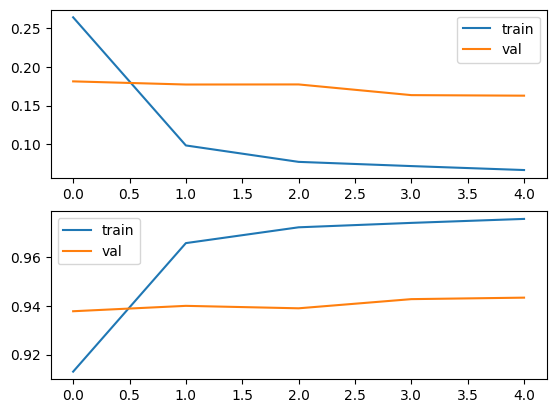

In [89]:
plt.subplot(211)
plt.plot(train_history['loss'], label='train')
plt.plot(val_history['loss'], label='val')
plt.legend()

plt.subplot(212)
plt.plot(train_history['accuracy'], label='train')
plt.plot(val_history['accuracy'], label='val')
plt.legend()

### Masking

**Задание** Проверьте себя - не считаете ли вы потери и accuracy на паддингах - очень легко получить высокое качество за счет этого.

У функции потерь есть параметр `ignore_index`, для таких целей. Для accuracy нужно использовать маскинг - умножение на маску из нулей и единиц, где нули на позициях паддингов (а потом усреднение по ненулевым позициям в маске).

**Задание** Посчитайте качество модели на тесте. Ожидается результат лучше бейзлайна!

In [90]:
do_epoch(model, criterion, (X_test, y_test), 512, name='test')

 test Loss = 0.16260, Accuracy = 94.41%: 100%|██████████| 28/28 [00:00<00:00, 50.30it/s]


(0.16259919745581491, tensor(0.9441, device='cuda:0'))

### Bidirectional LSTM

Благодаря BiLSTM можно использовать сразу оба контеста при предсказании тега слова. Т.е. для каждого токена $w_i$ forward LSTM будет выдавать представление $\mathbf{f_i} \sim (w_1, \ldots, w_i)$ - построенное по всему левому контексту - и $\mathbf{b_i} \sim (w_n, \ldots, w_i)$ - представление правого контекста. Их конкатенация автоматически захватит весь доступный контекст слова: $\mathbf{h_i} = [\mathbf{f_i}, \mathbf{b_i}] \sim (w_1, \ldots, w_n)$.

![BiLSTM](https://www.researchgate.net/profile/Wang_Ling/publication/280912217/figure/fig2/AS:391505383575555@1470353565299/Illustration-of-our-neural-network-for-POS-tagging.png)  
*From [Finding Function in Form: Compositional Character Models for Open Vocabulary Word Representation](https://arxiv.org/abs/1508.02096)*

**Задание** Добавьте Bidirectional LSTM.

In [152]:
class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super(LSTMTagger, self).__init__()

        self.word_embeddings = nn.Embedding(vocab_size, word_emb_dim)
        self.lstm = nn.LSTM(input_size=word_emb_dim, hidden_size=lstm_hidden_dim, num_layers=lstm_layers_count, bidirectional=True)
        self.output = nn.Linear(2*lstm_hidden_dim, tagset_size) # 2 because concat fi and bi

    def forward(self, inputs):
        word_emb =  self.word_embeddings(inputs)
        lstm_out, (h, c) = self.lstm(word_emb)
        tag_space = self.output(lstm_out)
        return F.log_softmax(tag_space, dim=1)


### Предобученные эмбеддинги

Мы знаем, какая клёвая вещь - предобученные эмбеддинги. При текущем размере обучающей выборки еще можно было учить их и с нуля - с меньшей было бы совсем плохо.

Поэтому стандартный пайплайн - скачать эмбеддинги, засунуть их в сеточку. Запустим его:

In [94]:
import gensim.downloader as api

w2v_model = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [124]:
w2v_model.similar_by_vector(w2v_model.get_vector('london') - w2v_model.get_vector('england') + w2v_model.get_vector('greece'))

[('moscow', 0.7004519104957581),
 ('greece', 0.696409285068512),
 ('athens', 0.6794896721839905),
 ('brussels', 0.6364588141441345),
 ('istanbul', 0.6362645030021667),
 ('paris', 0.62820965051651),
 ('helsinki', 0.6220876574516296),
 ('tokyo', 0.6192343235015869),
 ('ankara', 0.6025993227958679),
 ('stockholm', 0.5900677442550659)]

In [126]:
w2v_model.most_similar('china')

[('beijing', 0.8378757834434509),
 ('chinese', 0.8370456695556641),
 ('taiwan', 0.8251469135284424),
 ('mainland', 0.7728948593139648),
 ('korea', 0.7463889122009277),
 ('hong', 0.7441108226776123),
 ('japan', 0.7408212423324585),
 ('vietnam', 0.7311980724334717),
 ('shanghai', 0.7294734120368958),
 ('thailand', 0.721368670463562)]

Построим подматрицу для слов из нашей тренировочной выборки:

In [141]:
len(word2ind), w2v_model.vectors.shape

(45441, (400000, 100))

In [142]:
known_count = 0
embeddings = np.zeros((len(word2ind), w2v_model.vectors.shape[1]))
for word, ind in word2ind.items():
    word = word.lower()
    try:
      embeddings[ind] = w2v_model.get_vector(word)
      known_count += 1
    except KeyError:
      pass

print('Know {} out of {} word embeddings'.format(known_count, len(word2ind)))

Know 38736 out of 45441 word embeddings


**Задание** Сделайте модель с предобученной матрицей. Используйте `nn.Embedding.from_pretrained`.

In [155]:
class LSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, embeddings, tagset_size, lstm_hidden_dim=64, lstm_layers_count=1):
        super().__init__()

        self.word_embeddings = nn.Embedding.from_pretrained(torch.from_numpy(embeddings), freeze=True)
        self.lstm = nn.LSTM(input_size=embeddings.shape[1], hidden_size=lstm_hidden_dim, num_layers=lstm_layers_count, bidirectional=True)
        self.output = nn.Linear(2*lstm_hidden_dim, tagset_size) # 2 because concat fi and bi

    def forward(self, inputs):
        word_emb =  self.word_embeddings(inputs)
        lstm_out, (h, c) = self.lstm(word_emb)
        tag_space = self.output(lstm_out)
        return F.log_softmax(tag_space, dim=1)

In [175]:
model = LSTMTaggerWithPretrainedEmbs(
    embeddings=embeddings,
    tagset_size=len(tag2ind)
).float().cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-8)

train_history, val_history = fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=10,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 10] Train: Loss = 0.21586, Accuracy = 93.50%: 100%|██████████| 572/572 [00:04<00:00, 139.39it/s]
[1 / 10]   Val: Loss = 0.12525, Accuracy = 95.96%: 100%|██████████| 13/13 [00:00<00:00, 68.19it/s]
[2 / 10] Train: Loss = 0.09608, Accuracy = 96.90%: 100%|██████████| 572/572 [00:04<00:00, 134.66it/s]
[2 / 10]   Val: Loss = 0.10847, Accuracy = 96.55%: 100%|██████████| 13/13 [00:00<00:00, 62.22it/s]
[3 / 10] Train: Loss = 0.08109, Accuracy = 97.39%: 100%|██████████| 572/572 [00:03<00:00, 144.26it/s]
[3 / 10]   Val: Loss = 0.10203, Accuracy = 96.72%: 100%|██████████| 13/13 [00:00<00:00, 68.47it/s]
[4 / 10] Train: Loss = 0.07316, Accuracy = 97.56%: 100%|██████████| 572/572 [00:03<00:00, 149.94it/s]
[4 / 10]   Val: Loss = 0.10721, Accuracy = 96.70%: 100%|██████████| 13/13 [00:00<00:00, 67.30it/s]
[5 / 10] Train: Loss = 0.06799, Accuracy = 97.74%: 100%|██████████| 572/572 [00:03<00:00, 144.01it/s]
[5 / 10]   Val: Loss = 0.10125, Accuracy = 96.77%: 100%|██████████| 13/13 [00:00<00:00, 56.33i

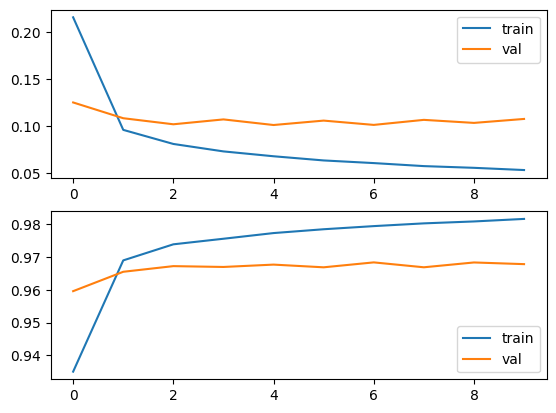

In [176]:
plt.subplot(211)
plt.plot(train_history['loss'], label='train')
plt.plot(val_history['loss'], label='val')
plt.legend()

plt.subplot(212)
plt.plot(train_history['accuracy'], label='train')
plt.plot(val_history['accuracy'], label='val')
plt.legend()

**Задание** Оцените качество модели на тестовой выборке. Обратите внимание, вовсе не обязательно ограничиваться векторами из урезанной матрицы - вполне могут найтись слова в тесте, которых не было в трейне и для которых есть эмбеддинги.

Добейтесь качества лучше прошлых моделей.

In [177]:
do_epoch(model, criterion, (X_test, y_test), 512, name='test')

 test Loss = 0.10797, Accuracy = 96.80%: 100%|██████████| 28/28 [00:00<00:00, 84.07it/s]


(0.10797342258904662, tensor(0.9680, device='cuda:0'))